In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [2]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [3]:
def set_params(params, guess_flux, yerrs):
    """
    Creating a GaussianProcess object for a Matern32Term kernel. 

    Parameters
    ----------
    params : array_like
        Containing Matern32Term kernel parameters.
        _sigma, _rho = params 
    
    guess_flux : array_like
        Containing the physical (batman) model flux.
    
    yerrs : array_like
        Containing an array of flux errors from TESS observations.

    Returns
    -------
    gp : GaussianProcess
        GaussianProcess object.

    """
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=guess_flux)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [4]:
TIC = 'TIC 66818296' #WASP-17 / TIC 66818296

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
lc_sector_12 = lc_collection[0].remove_nans()
lc_sector_38 = lc_collection[1].remove_nans()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))
#Sector 12 and sector 38
lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 66818296" SECTOR=12 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 66818296" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [5]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

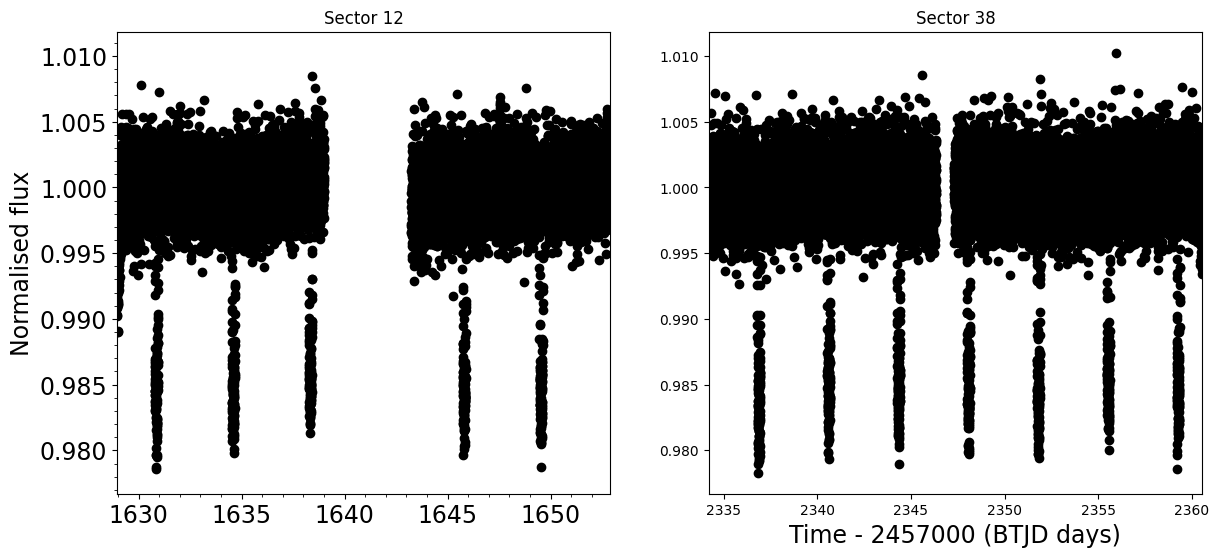

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

#Sector 12
ax1.set_title("Sector 12")
# ax1.scatter(lc.time.btjd, lc.flux, color='Black') #Unbinned
ax1.scatter(t, flux_data, color='Black') #Raw
ax1.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))

#Sector 38
ax2.set_title("Sector 38")
# ax2.scatter(lc.time.btjd, lc.flux, color='Black') #Unbinned
ax2.scatter(t, flux_data, color='Black') #Raw
ax2.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))


ax1.set_ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax1.xaxis.set_tick_params(labelsize=17)
ax1.yaxis.set_tick_params(labelsize=17)

ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [7]:
filename = "WASP_17b_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [8]:
#batman model
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R*

#GP model
model_sigma = np.percentile(flat_samples[:, 5], 50)
model_rho = np.percentile(flat_samples[:, 6], 50)

prior_Rs = 1.583 #R_sun Southworth et al. 2012

model_params = batman.TransitParams()
model_params.t0 = model_T0
model_params.per = model_per
model_params.rp = model_Rp
model_params.a = model_a
model_params.inc = model_inc
model_params.ecc = 0.0 #Fixed to zero for WASP_17b
model_params.w = 90.
model_params.limb_dark = "quadratic"
model_params.u = [0.20660467695878587, 0.2888055783310062] #Estimated by WASP_17b_ldc.ipynb

m = batman.TransitModel(model_params, t) #Use TESS time series, t
batman_model = m.light_curve(model_params)

In [9]:
gp = set_params([model_sigma, model_rho], batman_model, yerrs)

filename = "WASP_17b_model_flux_sigma.p"

if os.path.exists(filename) == True:
    with open(filename, "rb") as f:
        model_flux, variance = pickle.load(f)
    f.close()
else:
    model_flux, variance = gp.predict(flux_data, t=t, return_var=True) #model flux = gp model + batman model
    sigma = np.sqrt(variance)

    file = open(filename, "wb")
    pickle.dump([model_flux, sigma], file)
    file.close()

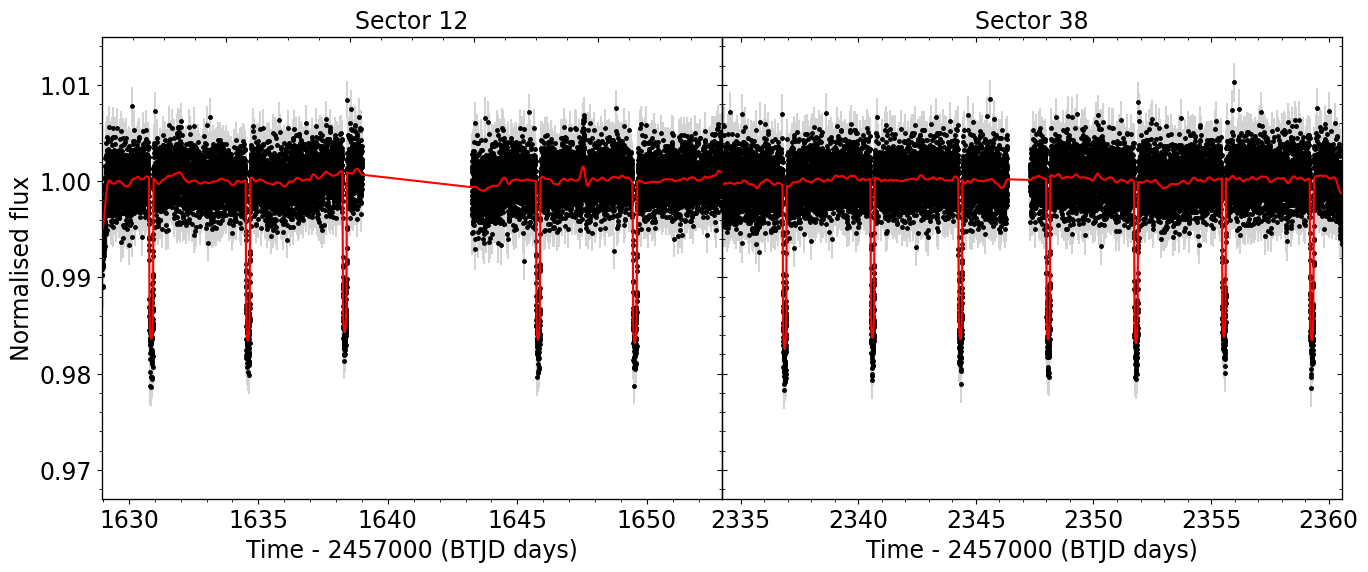

In [16]:
#Systematic model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

#Sector 12
ax1.set_title("Sector 12", size=17)
#Binned data?
ax1.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax1.plot(t, model_flux, color='Red')
# ax1.fill_between(t, mu - sigma, mu + sigma, color='Red', zorder=10)
ax1.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))

ax1.set_ylim([0.967, 1.015])

# Mirror y
ax1A = ax1.twinx()
ax1A.set_ylim(ax1.get_ylim())
ax1A.get_yaxis().set_ticklabels([])
ax1A.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
ax1B = ax1.twiny()
ax1B.set_xlim(ax2.get_xlim())
ax1B.get_xaxis().set_ticklabels([])
ax1B.tick_params(which="both", direction="in")


#Sector 38
ax2.set_title("Sector 38", size=17)
#Binned data?
ax2.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax2.plot(t, model_flux, color='Red', zorder=10)
ax2.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))
ax2.set_ylim(ax1.get_ylim()) #Mirror ax1 ylims

ax2.get_yaxis().set_ticklabels([])
ax2.tick_params(axis="y",which="both", direction="in")

# Mirror y
ax2A = ax2.twinx()
ax2A.set_ylim(ax2.get_ylim())
ax2A.get_yaxis().set_ticklabels([])
ax2A.tick_params(which="both", direction="in")

# Mirror x
ax2B = ax2.twiny()
ax2B.set_xlim(ax2.get_xlim())
ax2B.get_xaxis().set_ticklabels([])
ax2B.tick_params(which="both", direction="in")



ax1.set_ylabel("Normalised flux", size=17)
ax1.set_xlabel("Time - 2457000 (BTJD days)", size=17)
ax2.set_xlabel("Time - 2457000 (BTJD days)", size=17)

ax1.yaxis.set_tick_params(labelsize=17)
ax1.xaxis.set_tick_params(labelsize=17)
ax2.xaxis.set_tick_params(labelsize=17)


ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1B.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1A.yaxis.set_minor_locator(tck.AutoMinorLocator())


ax2.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2B.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2A.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.subplots_adjust(wspace=0)
plt.show()


In [11]:
# kernel = terms.Matern32Term(sigma = model_sigma, rho = model_rho)
# gp = celerite2.GaussianProcess(kernel, mean=0.0)
# gp.compute(t)
# model_flux = gp.sample()

#Detrending the flux data
gp_model = model_flux - batman_model
detrended_flux_data = flux_data - gp_model

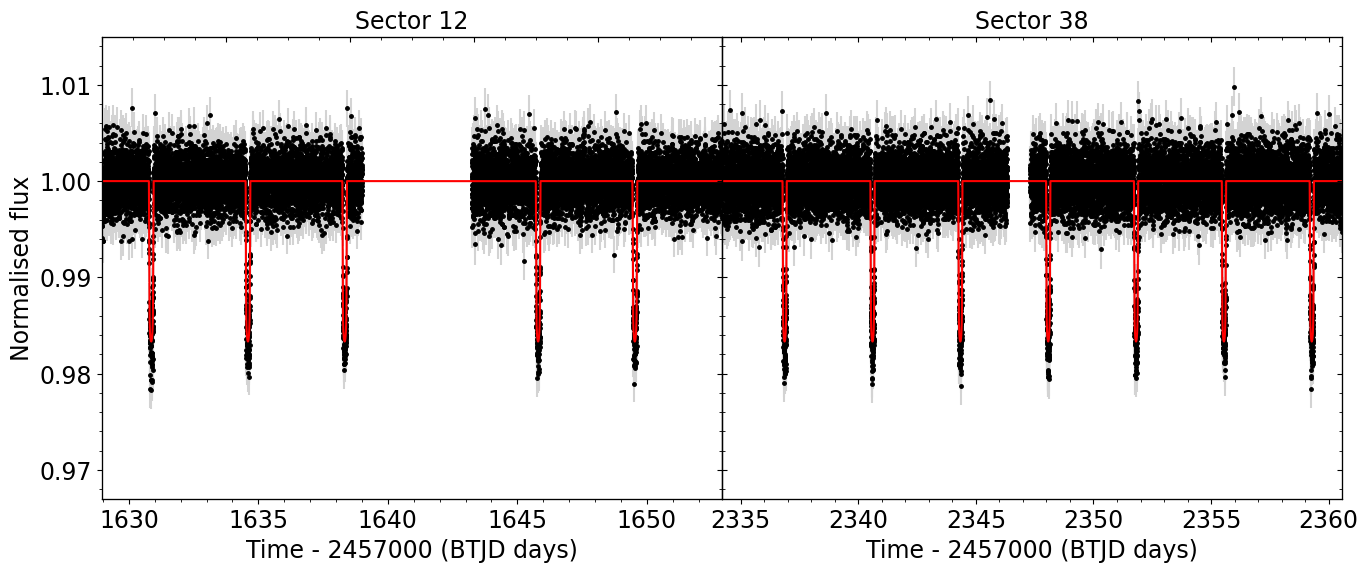

In [12]:
#Detrended flux data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

#Sector 12
ax1.set_title("Sector 12", size=17)
ax1.errorbar(t, detrended_flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax1.plot(t, batman_model, color='Red', zorder=10)
ax1.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))

ax1.set_ylim([0.967, 1.015])

# Mirror y
ax1A = ax1.twinx()
ax1A.set_ylim(ax1.get_ylim())
ax1A.get_yaxis().set_ticklabels([])
ax1A.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
ax1B = ax1.twiny()
ax1B.set_xlim(ax2.get_xlim())
ax1B.get_xaxis().set_ticklabels([])
ax1B.tick_params(which="both", direction="in")


#Sector 38
ax2.set_title("Sector 38", size=17)
#Binned data?
ax2.errorbar(t, detrended_flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax2.plot(t, batman_model, color='Red', zorder=10)
ax2.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))
ax2.set_ylim(ax1.get_ylim()) #Mirror ax1 ylims

ax2.get_yaxis().set_ticklabels([])
ax2.tick_params(axis="y",which="both", direction="in")

# Mirror y
ax2A = ax2.twinx()
ax2A.set_ylim(ax2.get_ylim())
ax2A.get_yaxis().set_ticklabels([])
ax2A.tick_params(which="both", direction="in")

# Mirror x
ax2B = ax2.twiny()
ax2B.set_xlim(ax2.get_xlim())
ax2B.get_xaxis().set_ticklabels([])
ax2B.tick_params(which="both", direction="in")



ax1.set_ylabel("Normalised flux", size=17)
ax1.set_xlabel("Time - 2457000 (BTJD days)", size=17)
ax2.set_xlabel("Time - 2457000 (BTJD days)", size=17)

ax1.yaxis.set_tick_params(labelsize=17)
ax1.xaxis.set_tick_params(labelsize=17)
ax2.xaxis.set_tick_params(labelsize=17)


ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1B.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1A.yaxis.set_minor_locator(tck.AutoMinorLocator())


ax2.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2B.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2A.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.subplots_adjust(wspace=0)
plt.show()


In [13]:

#Model folding
# model_flux = gp.predict(t=t)

residual = detrended_flux_data - model_flux

#Detrended flux data folding
lc_folded = lk.LightCurve(time=t, flux=detrended_flux_data, flux_err=yerrs).fold(model_per, model_T0)
t_folded = np.array(lc_folded.time.value)
detrended_flux_folded = np.array(lc_folded.flux)
yerrs_folded = np.array(lc_folded.flux_err)

#Phase folding model 
folded_model = lk.LightCurve(time=t, flux=batman_model).fold(model_per, model_T0)
folded_model_flux = np.array(folded_model.flux)
folded_model_time = np.array(folded_model.time.value)

#Phase folding residuals
folded_residuals = lk.LightCurve(time=t, flux=residual).fold(model_per, model_T0)
folded_residuals_flux = np.array(folded_residuals.flux)
folded_residuals_time = np.array(folded_residuals.time.value)


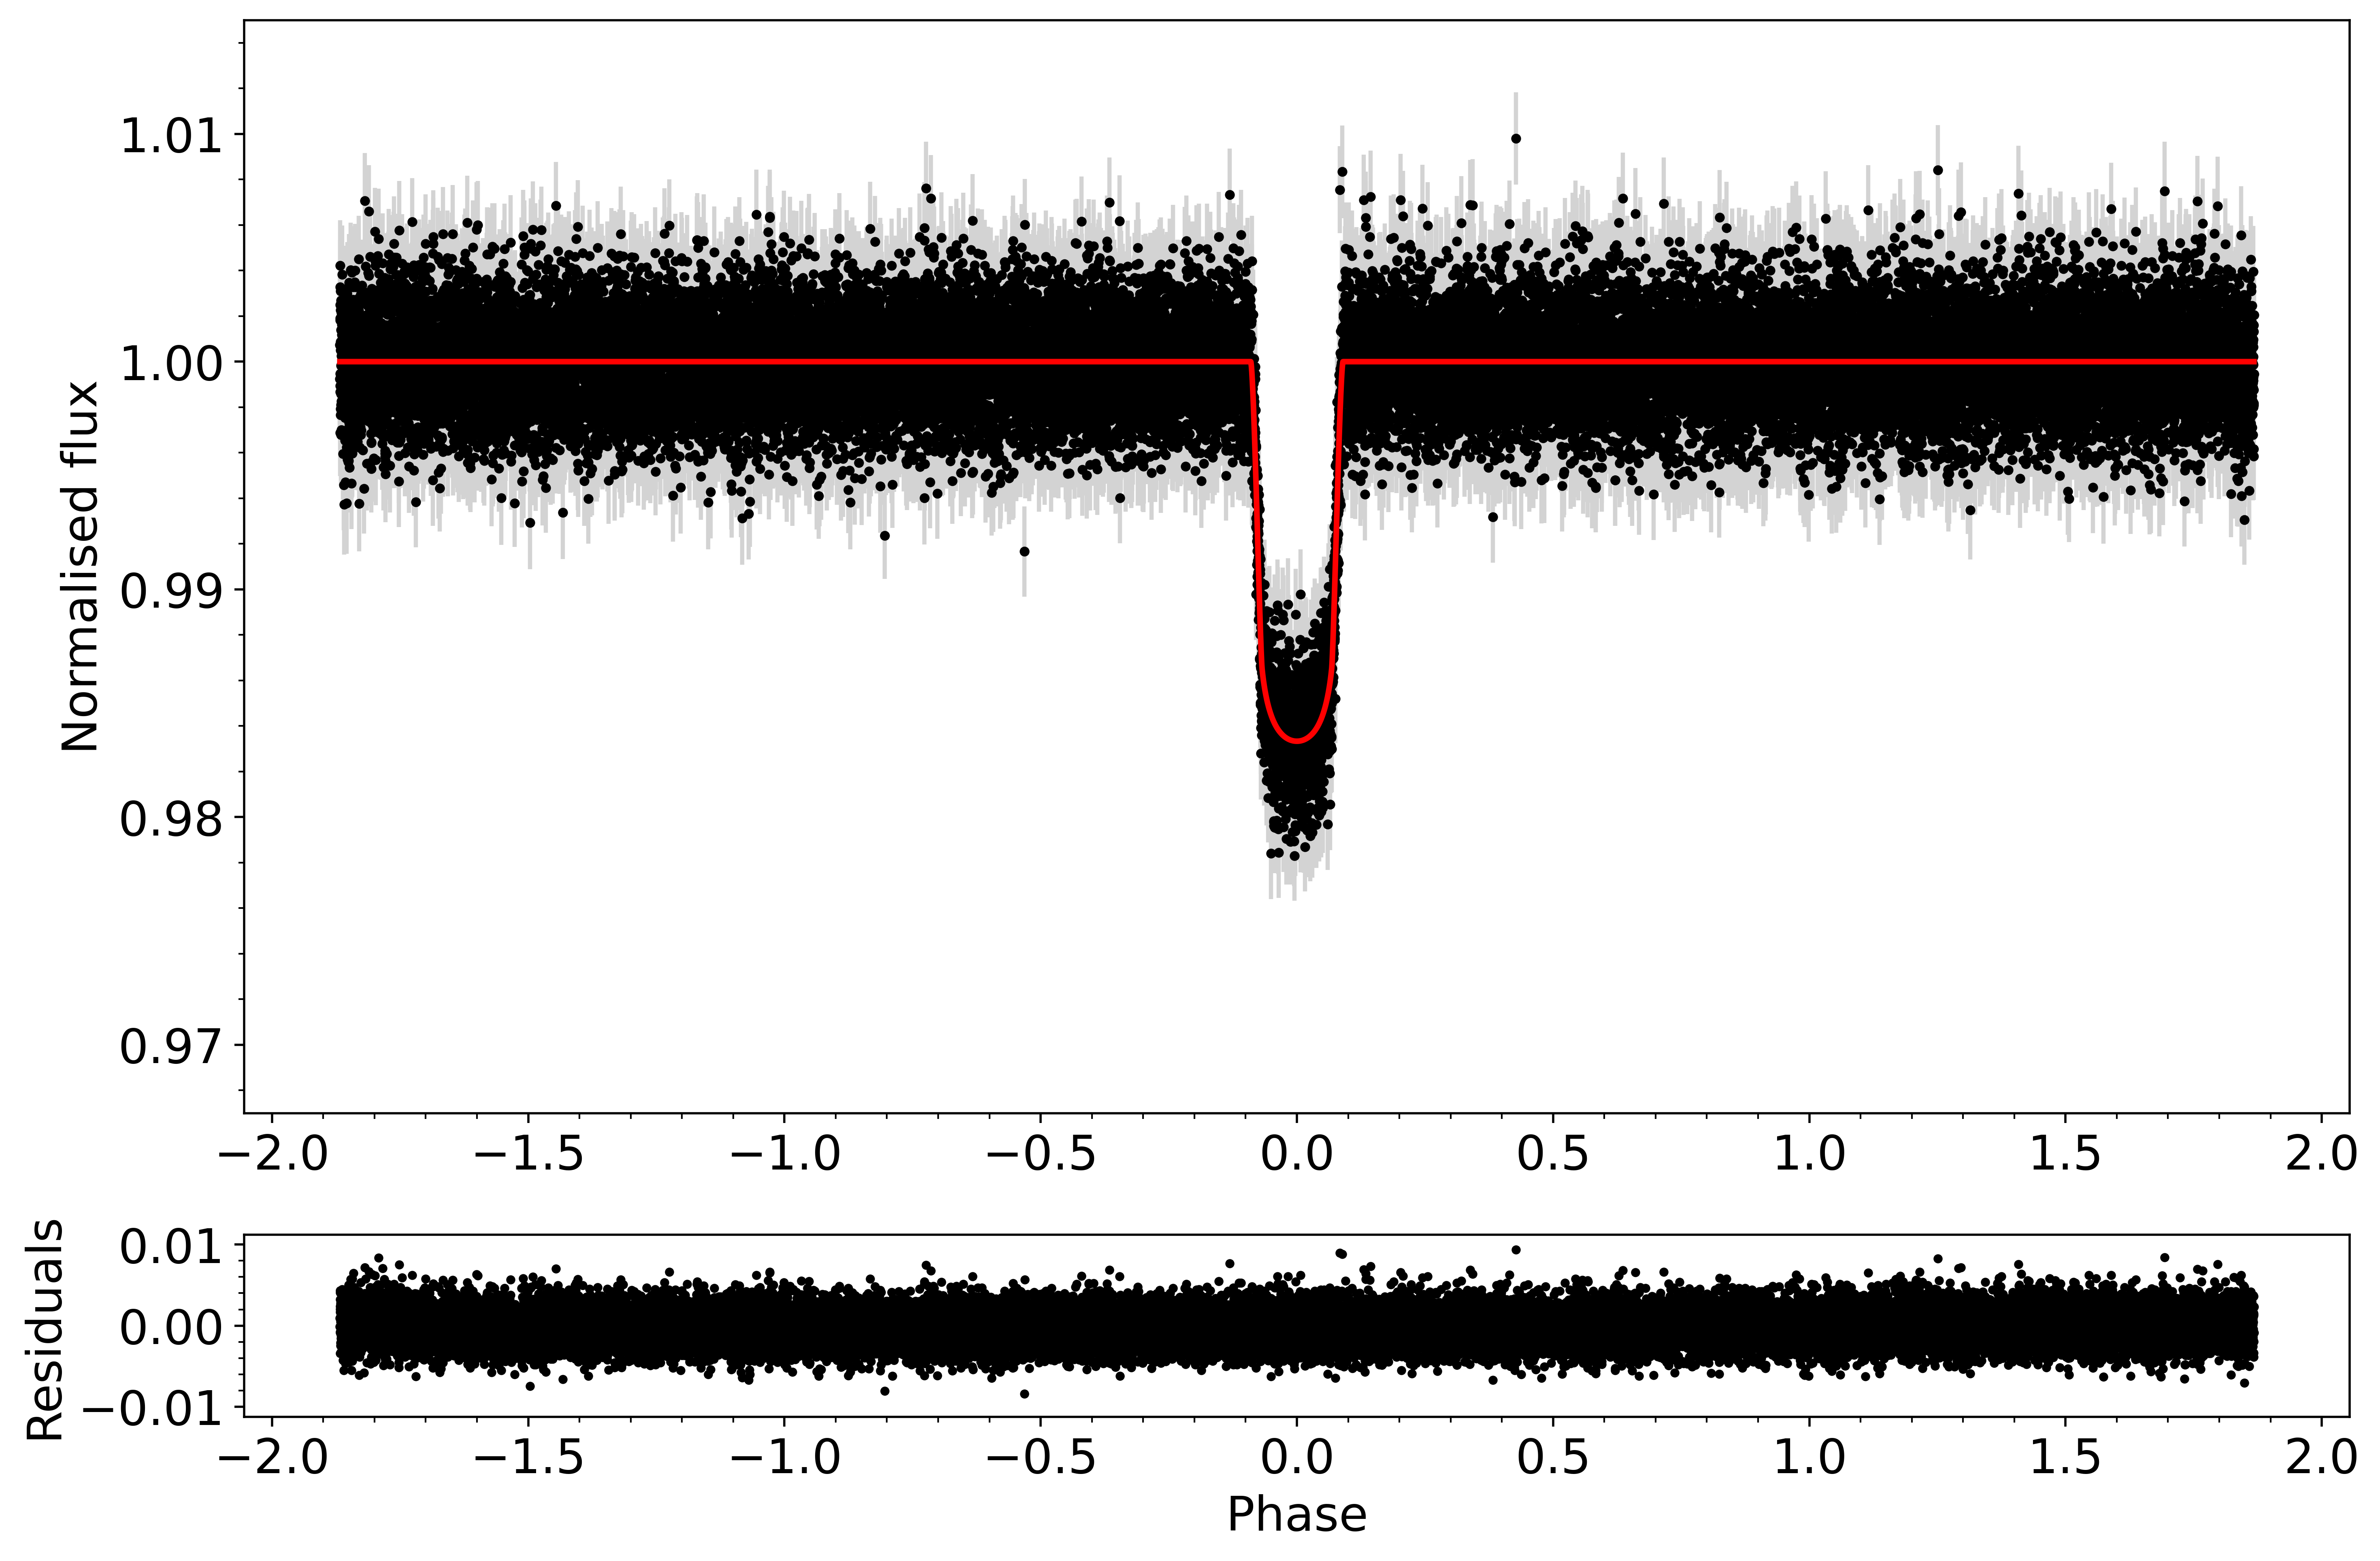

In [15]:
#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(16, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t_folded, detrended_flux_folded, yerr=yerrs_folded,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0)
ax.plot(folded_model_time, folded_model_flux, color='red',label="Model", lw=2, zorder=10)

ax.set(ylabel="Normalised flux")
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

# ax.legend(prop={'size': 14}, loc="lower right")

ax.set_ylim([0.967, 1.015])

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Bottom panel
ax_res.scatter(folded_residuals_time, folded_residuals_flux, color='black', s=5)
ax_res.set_ylim((-max(abs(folded_residuals_flux))*1.2, max(abs(folded_residuals_flux)*1.2)))


ax_res.set(xlabel="Phase", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()